# Titanic Tutorial(타이타닉 튜토리얼)

- 만약 데이터 사이언스, 머신러닝 또는 캐글에서 어떤 것을 해야하는지 모르는 newbie라면, 타이타닉을 하시는 게 가장 좋은 선택입니다.
- 타이타닉은 아시다시피, 사상 최대 해난사고로써, 1,500여명의 희생자가 생겼습니다.
- 우리는 이 튜토리얼에서 타이타닉에 탑승한 사람들의 신상정보를 활용하여, 승선한 사람들의 생존여부를 예측하는 모델을 생성할 것입니다. 
- 본 튜토리얼에서는 여러 시각화 도구(matplotlib, seaborn, plotly), 데이터 분석 도구(pandas, numpy), 머신러닝 도구(sklearn)을 사용할 것입니다.
- 본 튜토리얼은 캐글에 있는 여러 커널들을 참조하여 만들었습니다. 본 튜토리얼을 공부하신 귀에 캐글 타이타닉 컴퍼티션에 존재하는 여러 다른 커널들을 더 공부하시면 됩니다. 
- 본 튜토리얼은 파이썬 문법에 여러 어려움이 없으셔야 수월할 것입니다. 여기서 사용하는 라이브러리들을 꺼본 경험이 있으면 좋겠지만, 경험이 없다더라도 한 줄씩 천천히 적어나가시면 충분히 하실 수 있습니다.

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)
#이 두줄은 필자가 항상 쓰는 방법입니다. matplotlib의 기본 scheme말고 seaborn scheme을 세팅하고, 일일이 graph의 font size를 지정할 필요 없이 seaborn의 font_scale을 사용하면 편합니다.
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import missingno as msno

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

앞으로 우리가 해야할 프로세스는 대략 아래와 같습니다.

1. 데이터셋 확인 - 대부분의 캐글 데이터들은 잘 정제외어 있습니다. 하지만 가끔 null data가 존재합니다. 이를 확인하고, 향후 수정합니다.
2. 탐색적 데이터 분석(exploratory data analysis) - 여러 feature들을 개별적으로 분석하고, feature들 간의 상관관계를 확인합니다. 여러 시각화 툴을 사용하여 insight를 얻습니다.
3. feature engineering - 모델을 세우기에 앞서, 모델의 성능을 높일 수 있도록 feature들을 engineering합니다. one-hot encoding, class로 나누기, 구간으로 나누가, 텍스트 데이처 처리 등을 말합니다.
4. model 만들기 - sklearn을 사용해 모델을 만듭니다. 파이썬에서 머신러닝을 할 때는 sklearn을 사용하면 수많은 알고리즘을 일관ㄱ된 문법으로 사용할 수 있습니다. 물론 딥러닝을 위해 tensorflow, pytorch 등을 사용할 수도 있습니다.
5. 모델 학습 및 예측 - trainset을 가지고 모델을 학습시킨 후, testset을 가지고 prediction합니다.
6. 모델 평가 - 예측 성능이 원하는 수준인지 판단합니다. 풀려는 문제에 따라 모델을 평가하는 방식도 달라집니다. 학습된 모델이 어떤 것을 학습하였는지 확인해봅니다. 

# 1. Dataset 확인

- 파이썬에서 테이블화된 데이터를 다루는 데 가장 최적화되어 있으며, 많이 쓰이는 라이브러리는 pandas입니다.
- 우리는 pandas를 사용하여 데이터셋의 간단한 통계적 분석부터, 복잡한 처리들을 간단한 메소드를 아용하여 해낼 수 있습니다.
- 파이썬으로 데이터 분석을 한다고 하면 반드시 능숙해져야 할 라이브러리이니, 여러 커널들을 공부하시면서 사용법에 익숙해지도록 반복 또 반복하시길 권장합니다.
- 캐글에서 데이터셋은 보통 train, test set으로 나뉘어 있습니다.

In [63]:
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')

In [64]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- 우리가 다루는 문제에서 feature는 Pclass, Age, SibSp, Parch, Fare이며, 예측하려는 target은 Survived입니다.

* Survived(생존여부, integer) target label, 1, 0으로 표현됨
* Pclass(티켓의 클래스, integer) 1 = 1st, 2 = 2nd, 3 = 3rd 클래스로 나뉘며 categorical feature
* Sex(성별, string) male, female로 구분되며 binary
* Age(나이, integer) continuous
* SibSp(함께 탑승한 형제와 배우자의 수, integer) quantitative
* Parch(함께 탑승한 부모와 아이의 수, integer) quantitative
* Ticket(티켓번호, string) alphabet + integer
* Fare(탑승료, float) continuous
* Cabin(객실번호, string) alphabet + integer
* Embarked(탑승항구, string) C = Cherbourg, Q = Queenstown, S = Southamton

- pandas dataframe에는 describe() 메소드가 있는데, 이를 쓰면 각 feature가 가진 통계치들을 반환해줍니다. 

In [65]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [66]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


- 테이블에서 보다시피, PassengerID 숫자와 다른, 그러니까 null data가 존재하는 열(feature)가 있는 것 같습니다.
- 이를 좀 더 보기 편하도록 그래프로 시각화해서 살펴봅시다.

## 1.1 Null Data Check

In [67]:
for col in df_train.columns:
    msg = 'column: {:>10}\t Percent of Nan Value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msg)

column: PassengerId	 Percent of Nan Value: 0.00%
column:   Survived	 Percent of Nan Value: 0.00%
column:     Pclass	 Percent of Nan Value: 0.00%
column:       Name	 Percent of Nan Value: 0.00%
column:        Sex	 Percent of Nan Value: 0.00%
column:        Age	 Percent of Nan Value: 19.87%
column:      SibSp	 Percent of Nan Value: 0.00%
column:      Parch	 Percent of Nan Value: 0.00%
column:     Ticket	 Percent of Nan Value: 0.00%
column:       Fare	 Percent of Nan Value: 0.00%
column:      Cabin	 Percent of Nan Value: 77.10%
column:   Embarked	 Percent of Nan Value: 0.22%


In [68]:
for col in df_test.columns:
    msg = 'column: {:>10}\t Percent of Nan Value: {:.2f}%'.format(col, 100 * (df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msg)

column: PassengerId	 Percent of Nan Value: 0.00%
column:     Pclass	 Percent of Nan Value: 0.00%
column:       Name	 Percent of Nan Value: 0.00%
column:        Sex	 Percent of Nan Value: 0.00%
column:        Age	 Percent of Nan Value: 20.57%
column:      SibSp	 Percent of Nan Value: 0.00%
column:      Parch	 Percent of Nan Value: 0.00%
column:     Ticket	 Percent of Nan Value: 0.00%
column:       Fare	 Percent of Nan Value: 0.24%
column:      Cabin	 Percent of Nan Value: 78.23%
column:   Embarked	 Percent of Nan Value: 0.00%


- Train, Test set에서 Age(둘 다 약 20%), Cabin(둘 다 약 80%), Embarked(train만 0.22%)로 null data가 존재하는 것을 볼 수 있습니다.
- MSNO라는 라이브러리를 사용하면 null data의 존재를 더 쉽게 볼 수 있습니다.

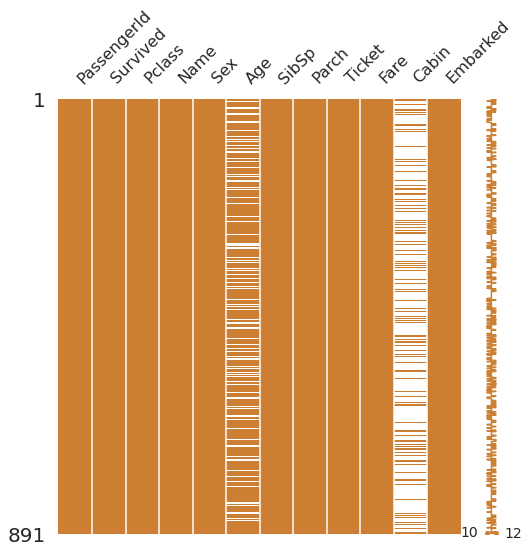

In [69]:
msno.matrix(df=df_train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

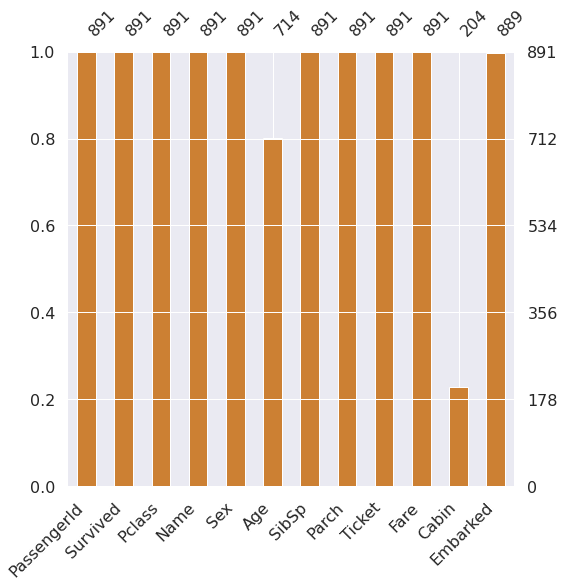

In [70]:
msno.bar(df=df_train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

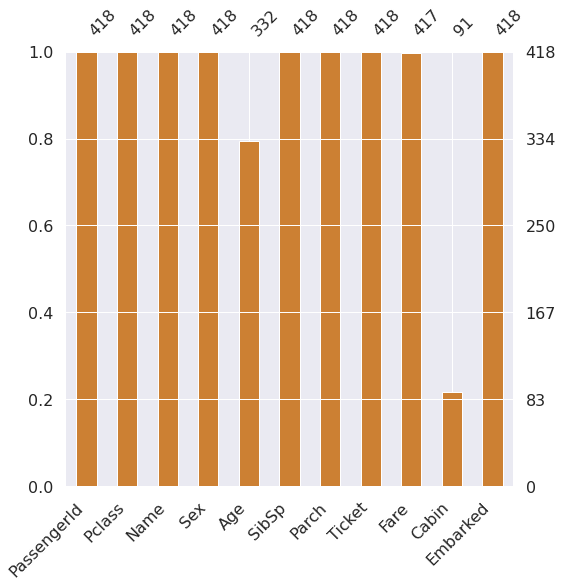

In [71]:
msno.bar(df=df_test.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

## 1.2 Target Label 확인

- target label이 어떤 distribution을 가지고 있는지 확인해봐야 합니다.
- 지금 같은 binary classification 문제의 경우에서, 1과 0의 분포가 어떻냐에 따라 모델의 평가 방법이 달라질 수 있습니다. 

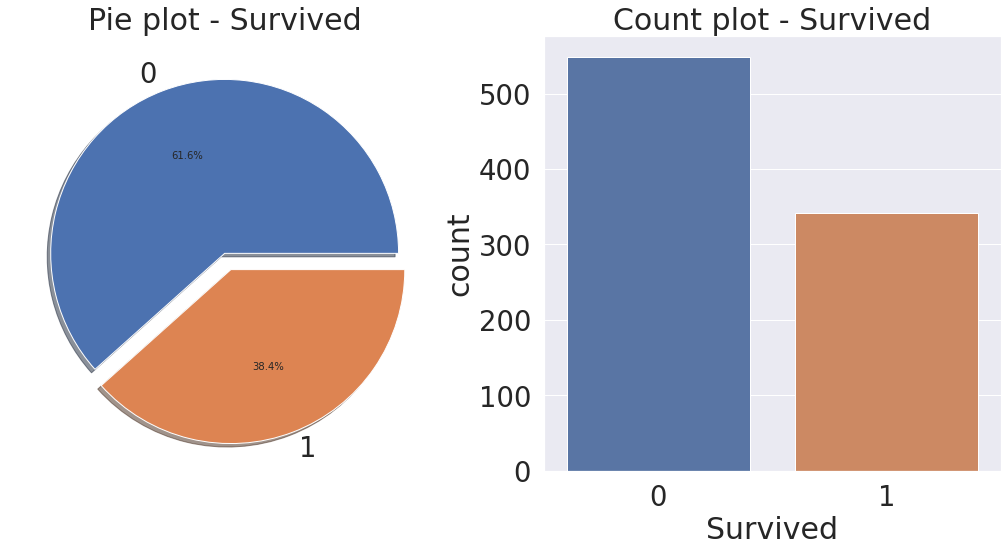

In [72]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')
sns.countplot('Survived', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()

- 안타깝게도 죽은 사람이 더 많습니다. 
- 38.4%가 살아남았습니다.
- target label의 분포가 제법 균일(balanced)합니다. 불균일한 경우, 예를 들어서 100 중 1이 99, 0이 1개인 경우에는 만약 모델이 모든 것을 1이라 해도 정확도가 99%가 나오게 됩니다. 0을 찾는 문제라면 이 모델을 원하는 결과를 줄 수 없게 됩니다. 지금 문제에서는 그렇지 않으니 계속 진행하겠습니다.

# 2. Exploratory Data Analysis

- 이제 본격적으로 데이터 분석을 해보겠습니다. 데이터는 매우 많습니다. 이 많은 데이터 안에 숨겨진 사실을 찾기 위해선 적절한 시각화가 필요합니다.
- 시각화 라이브러리는 matplotlib, seaborn, plotly 등이 있습니다. 특정 목적에 맞는 소스코드를 정리해두어 필요할 때마다 참고하면 편합니다. 

## 2.1 Pclass

- 먼저 Pclass에 대해서 살펴보겠습니다. Pclass는 ordinal, 서수형 데이터입니다. 카테고리이면서, 순서가 있는 데이터 타입입니다. 
- 먼저 Pclass에 따른 생존율의 차이를 살펴보겠습니다. 엑셀의 피벗 차트와 유사한 작업을 하게 되는데, pandas dataframe에서는 groupby를 사용하면 쉽게 할 수 있습니다. 또한 pivot이라는 메소드도 있습니다.
- 'Pclass', 'Survived'를 가져온 후, Pclass로 묶습니다. 그러고 나면 각 Pclass마다 0, 1이 count가 되는데, 이를 평균내면 각 Pclass별 생존률이 나옵니다.
- 아래와 같이 count()를 하면, 각 class에 몇명이 있는지 확인할 수 있으며, sum()을 하면, 216명 중 생존한(Survived = 1) 사람의 총합을 알 수 있습니다.

In [73]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).count()

,Survived
Pclass,
1,216
2,184
3,491


In [74]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).sum()

,Survived
Pclass,
1,136
2,87
3,119


- pandas의 crosstab을 사용하면 좀 더 위 과정을 좀 더 수월하게 볼 수 있습니다.

In [75]:
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True).style.background_gradient(cmap='Set2')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


- grouped 객체에 mean()을 하게 되면 각 클래스별 생존률을 얻을 수 있습니다. class 1 이면 아래와 같습니다.
- 136 / (80+136) ≈ 0.63

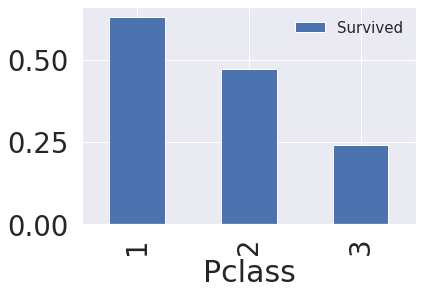

In [76]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar()
plt.legend(loc=1, prop={'size':15})

- 보다시피, Pclasse가 좋을 수록(1st) 생존률이 높은 것을 확인할 수 있습니다.
- 좀 더 보기 쉽게 그래프를 그려보겠습니다. seaborn의 countplot을 이용하면, 특정 label에 따른 개수를 확인해 볼 수 있습니다. 

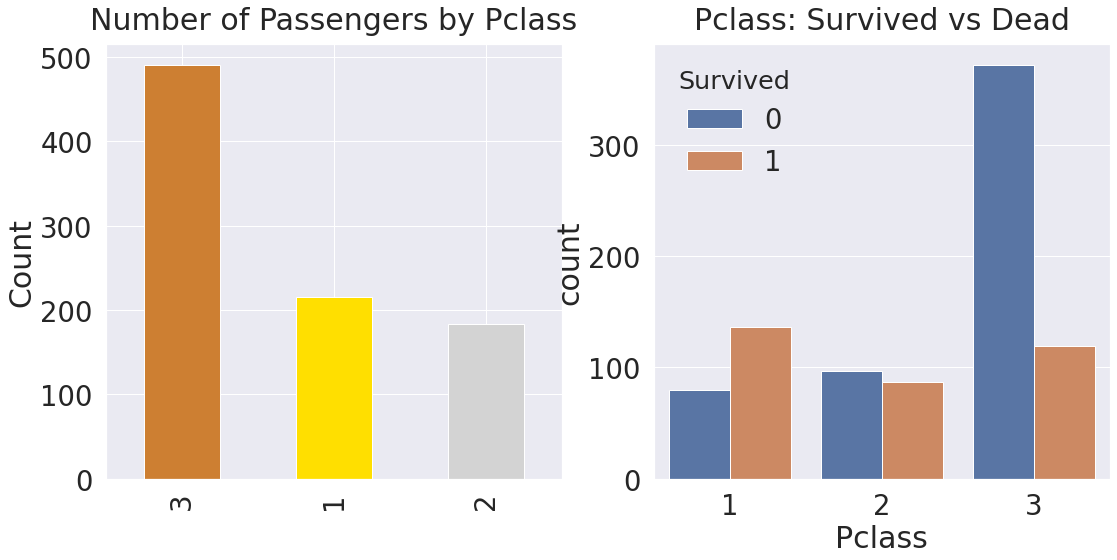

In [77]:
y_position = 1.02
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train['Pclass'].value_counts().plot.bar(color=['#CD7F32', '#FFDF00', '#D3D3D3'], ax=ax[0])
ax[0].set_title('Number of Passengers by Pclass', y=y_position)
ax[0].set_ylabel('Count')
sns.countplot('Pclass', hue='Survived',  data=df_train, ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead', y=y_position)
plt.show()

- 클래스가 높을 수록, 생존 확률이 높은 걸 확인할 수 있습니다. Pclass 1, 2, 3 순서대로 63%, 48%, 25% 입니다.
- 우리는 생존에 Pclass가 큰 영향을 미친다고 생각해볼 수 있으며, 나중에 모델을 세울 때 이 feature를 사용하는 것이 좋을 것이라 판단할 수 있습니다.

## 2.2 Sex

- 이번에는 성별로 생존률이 어떻게 달라지는지 확인해보겠습니다.
- 마찬가지로 pandas groupby와 seaborn countplot을 사용해서 시각화해봅시다.

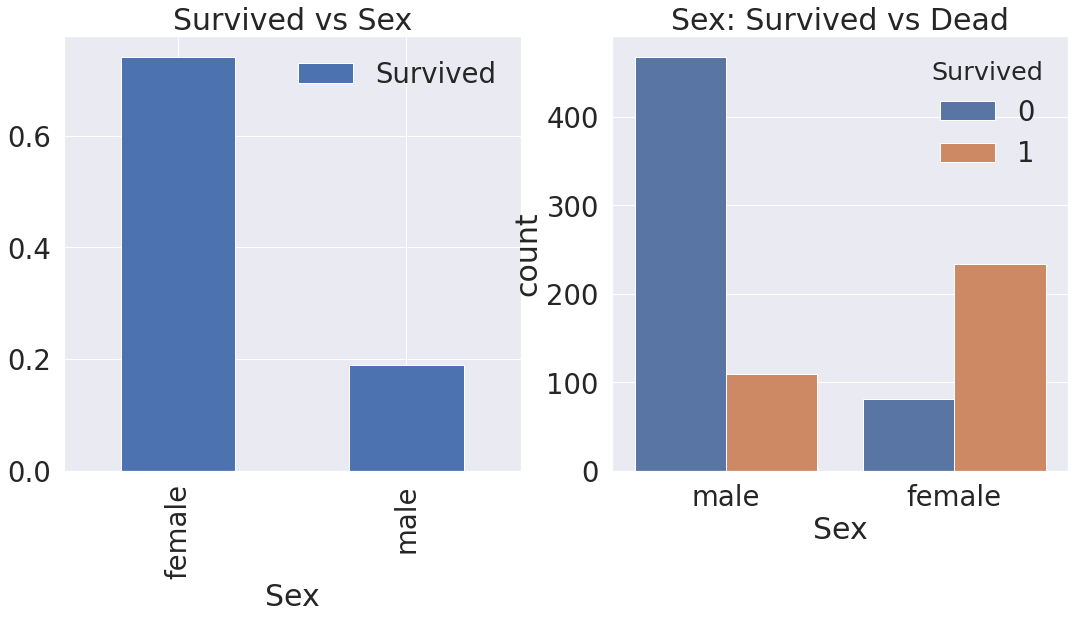

In [78]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

- 보시다시피, 여자가 생존할 확률이 높습니다.

In [79]:
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [80]:
pd.crosstab(df_train['Sex'], df_train['Survived'], margins=True).style.background_gradient(cmap='Set2')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


- Pclass와 마찬가지로, Sex도 예측 모델에 쓰일 중요한 feature임을 알 수 있습니다.

## 2.3 Both Sex and Pclass

- 이번에는 Sex, Pclass 두가지에 관하여 생존이 어떻게 달라지는지 확인해봅시다.
- seaborn의 factorplot을 이용하면, 손쉽게 3개의 차원으로 이루어진 그래프를 그릴 수 있습니다.

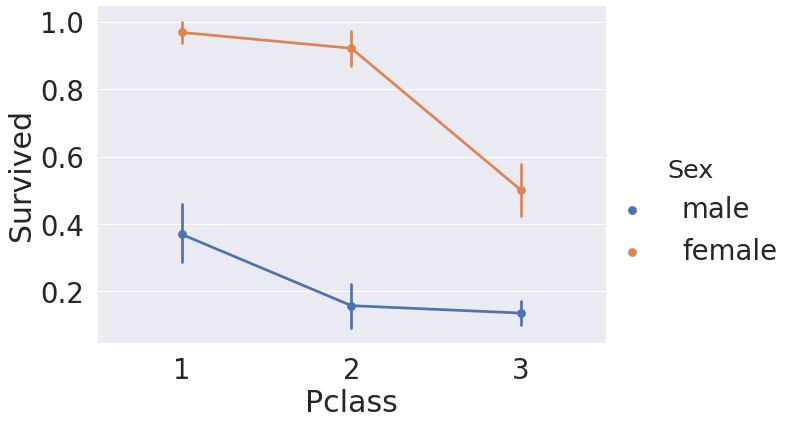

In [81]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=df_train, size=6, aspect=1.5)

- 모든 클래스에서 female이 살 확률이 male보다 높은 것을 알 수 있습니다.
- 또한, 남자, 여자 상관없이 클래스가 높을수록 살 확률이 높습니다
- 위 그래프는 hue 대신 column으로 하면 아래와 같아집니다.

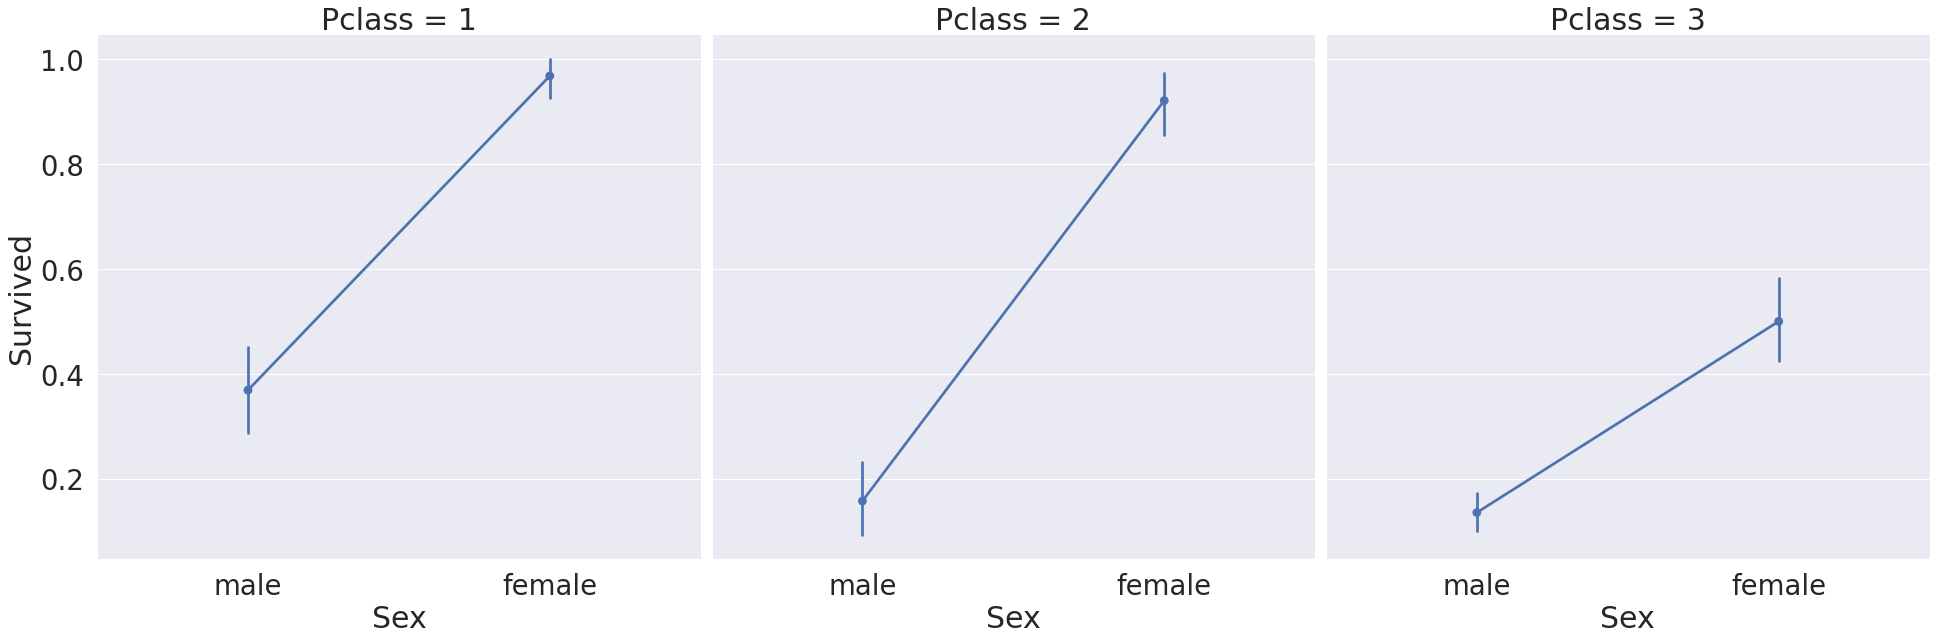

In [82]:
sns.factorplot(x='Sex', y='Survived', col='Pclass', data=df_train, satureaction=0.5, size=9, aspect=1)

## 2.4 Age

- 이번에는 Age feature를 살펴봅시다.

In [83]:
print('제일 나이 많은 탑승객: {:.1f} Years'.format(df_train['Age'].max()))
print('제일 나이 어린 탑승객: {:.1f} Years'.format(df_train['Age'].min()))
print('탑승객 평균 나이: {:.1f} Years'.format(df_train['Age'].mean()))

제일 나이 많은 탑승객: 80.0 Years
제일 나이 어린 탑승객: 0.4 Years
탑승객 평균 나이: 29.7 Years


- 생존에 따른 Age의 히스토그램을 그려보겠습니다.

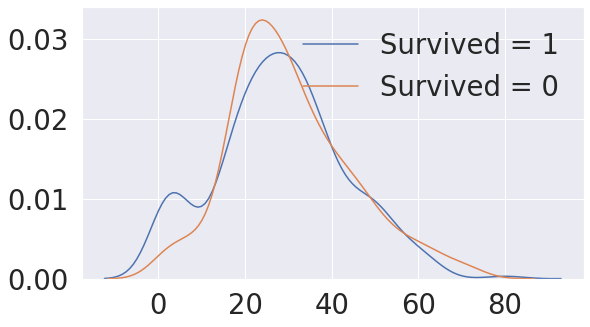

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'], ax=ax)
plt.legend(['Survived = 1', 'Survived = 0'])
plt.show()

- 보시다시피, 생존자 중 나이가 어린 경우가 많음을 볼 수 있습니다.

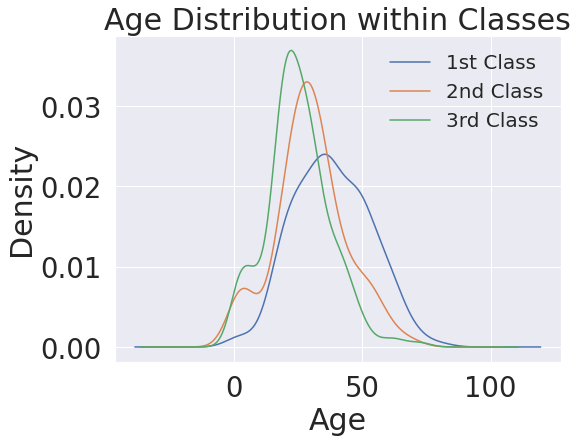

In [85]:
#Age distribution within classes
plt.figure(figsize=(8, 6))
df_train['Age'][df_train['Pclass'] == 1].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 2].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within Classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'], prop={'size': 20})
plt.show()

- Class가 높을수록 나이 많은 사람의 비중이 커짐
- 나이대가 변하면서 생존률이 어떻게 되는지 보려고 합니다.
- 나이 범위를 점점 넓혀가며, 생존률이 어떻게 되는지 한번 봅시다.

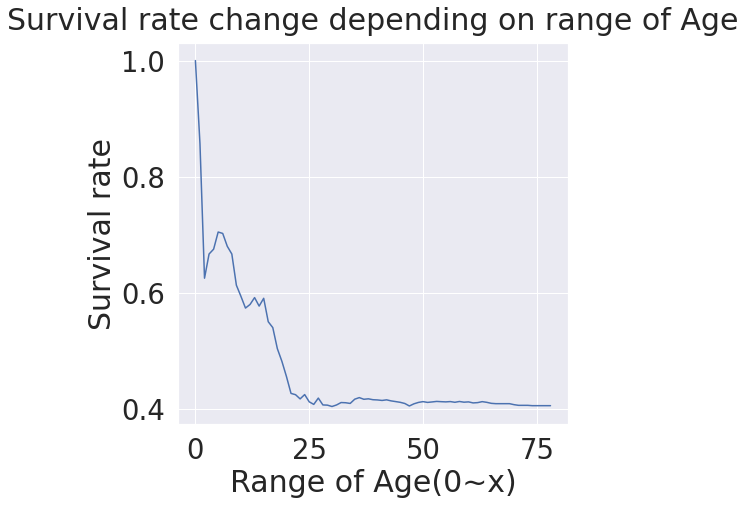

In [86]:
cummulate_survival_ratio = []
for i in range(1, 80):
    cummulate_survival_ratio.append(df_train[df_train['Age'] < i]['Survived'].sum() / len(df_train[df_train['Age'] < i]['Survived']))

plt.figure(figsize=(7, 7))
plt.plot(cummulate_survival_ratio)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0~x)')
plt.show()

- 보시다시피, 나이가 어릴수록 생존률이 확실히 높은 것을 확인할 수 있습니다.
- 우리는 이 나이가 중요한 feature로 쓰일 수 있음을 확인했습니다.

## 2.5 Pclass, Sex, Age

- 지금까지 본 Sex, Pclass, Age, Survived 모두에 대해서 보고 싶습니다. 이를 쉽게 그려주는 것이 seaborn의 violinplot입니다.
- x축은 우리가 나눠서 보고 싶어하는 case(여기선 Pclass, Sex)를 나타내고, y축은 보고 싶어하는 distribution(Age)입니다.
- 한번 그려보겠습니다.

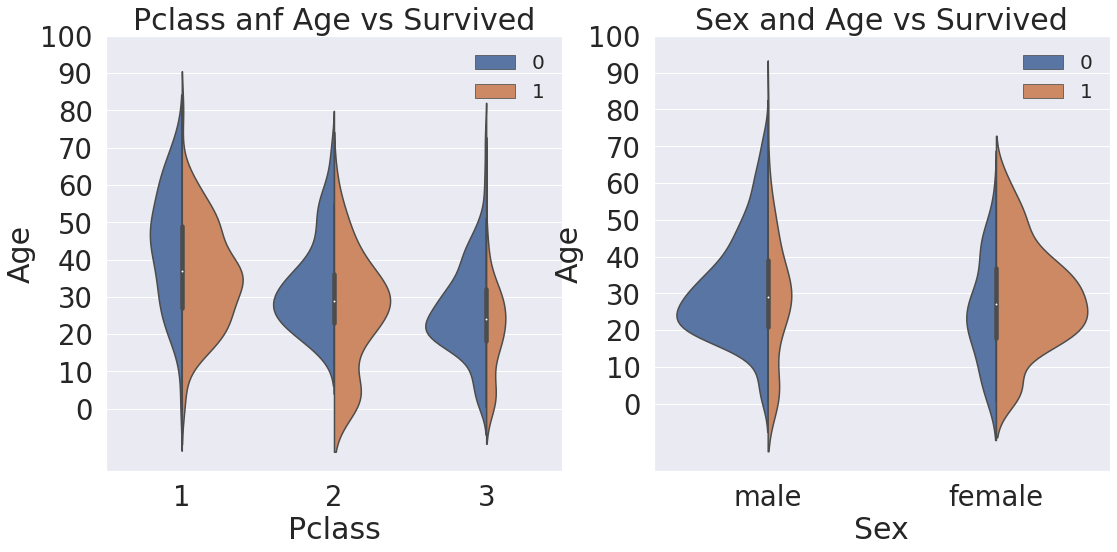

In [87]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.violinplot('Pclass', 'Age', hue='Survived', data=df_train, scale='count', split=True, ax=ax[0])
ax[0].set_title('Pclass anf Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))
ax[0].legend(loc='upper right', prop={'size': 20})
sns.violinplot('Sex', 'Age', hue='Survived', data=df_train, scale='count', split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))
ax[1].legend(loc='upper right', prop={'size': 20})
plt.show()

- 왼쪽 그림은 Pclass별로 Age의 distribution이 어떻게 다른지, 거기에 생존여부에 따라 구분한 그래프입니다.
- 오른쪽 그림도 마찬가지로 Sex에 따른 Age의 distribution이 어떻게 다른지 보여주는 그래프입니다.
- 생존만 봤을 때, 모든 클래스에서 나이가 어릴수록 생존을 많이 한 것을 볼 수 있습니다.
- 오른쪽 그림에서 보면, 명확히 여자가 생존을 많이 한 것을 볼 수 있습니다.
- 여성과 아이를 먼저 챙긴 것을 알 수 있습니다.

## 2.6 Embarked

- Embarked는 탑승한 항구를 나타냅니다.
- 위에서 해왔던 것과 비슷하게 탑승한 곳에 따른 생존률을 보겠습니다.

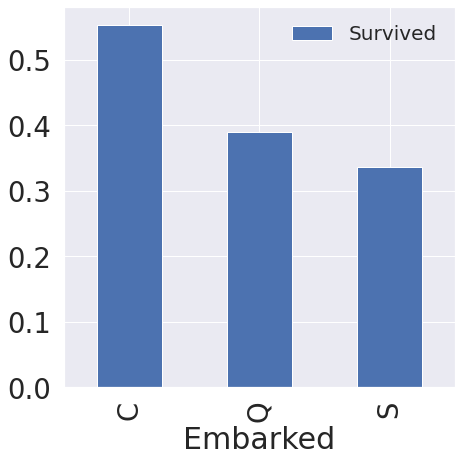

In [88]:
f, ax = plt.subplots(1, 1, figsize=(7, 7))
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax)
plt.legend(prop={'size':20})

- 보시다시피 조금 차이는 있지만 생존률은 좀 비슷한 것 같습니다. 그래도 C가 제일 높군요.
- 모델에 얼마나 큰 영향을 미칠지는 모르겠지만, 그래도 사용하겠습니다.
- 사실 모델을 만들고 나면 우리가 사용한 feature들이 얼마나 중요한 역할을 했는지 확인해볼 수 있습니다. 이는 추후에 모델을 만들고 난 다음에 살펴볼 것입니다.
- 다른 feature로 split하여 한번 살펴보겠습니다.

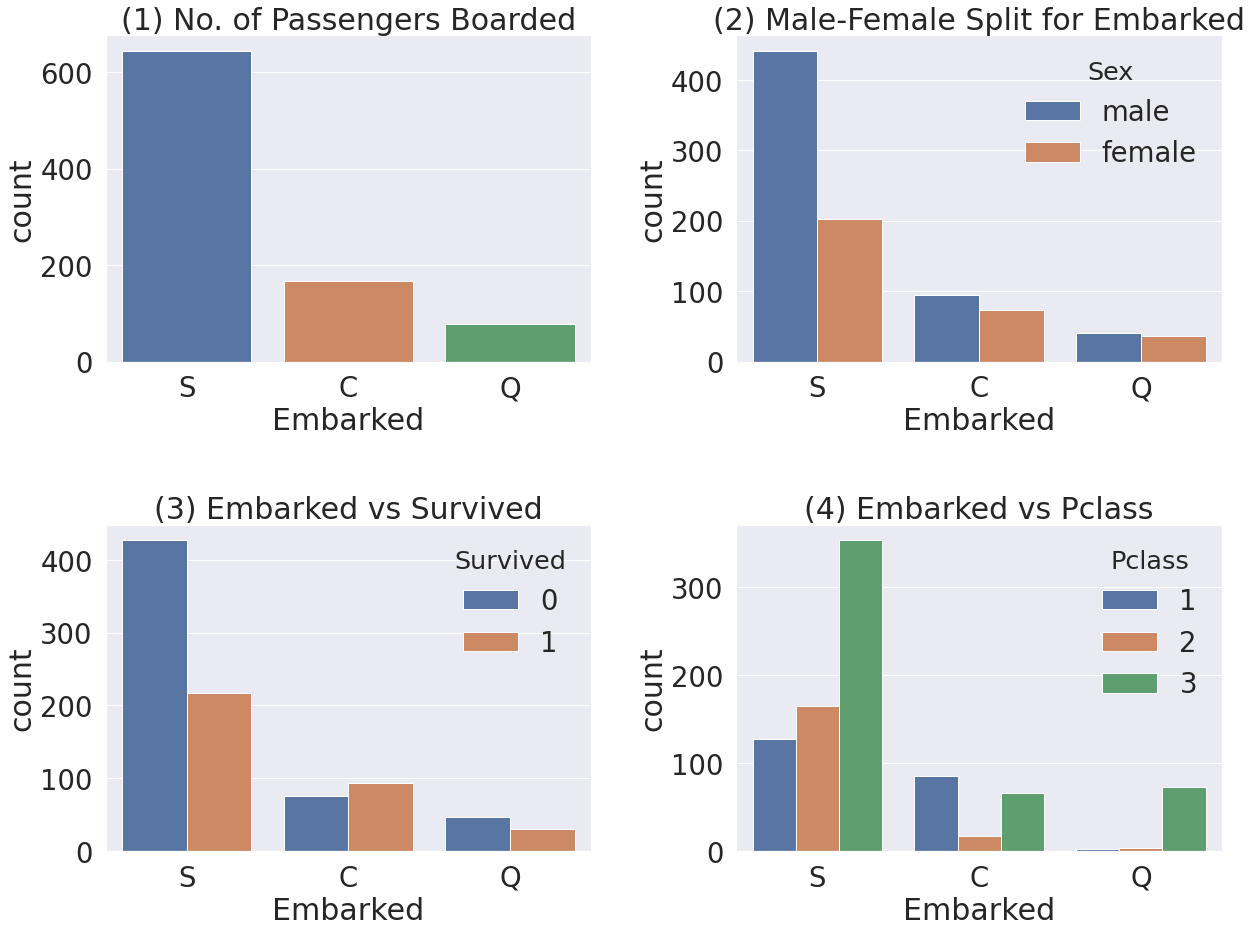

In [89]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))
sns.countplot('Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No. of Passengers Boarded')
sns.countplot('Embarked', hue='Sex', data=df_train, ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')
sns.countplot('Embarked', hue='Survived', data=df_train, ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')
sns.countplot('Embarked', hue='Pclass', data=df_train, ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

- Figure(1) -> 전체적으로 봤을 때, S에서 가장 많은 사람이 탑승했습니다.
- Figure(2) -> C와 Q는 남녀 비율이 비슷하고, S는 남자가 더 많습니다.
- Figure(3) -> 생존확률이 S의 경우 많이 낮은 걸 볼 수 있습니다. (이전 그래프에서 봤었습니다)
- Figure(4) -> Class로 split해서 보니, C가 생존확률이 높은 건 Class가 높은 사람이 많이 타서 그렇습니다. S는 3rd class가 많아서 생존확률이 낮게 나옵니다.

## 2.7 Family - SibSp(형제, 자매) + Parch(부모, 자녀)

- SibSp와 Parch를 합하면 Family가 될 것입니다. Family로 합쳐서 분석해봅시다.

In [90]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 #자신을 포함해야하니 1을 더합니다
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

In [91]:
print('Maximum size of Family:', df_train['FamilySize'].max())
print('Minimum size of Family:', df_train['FamilySize'].min())

Maximum size of Family: 11
Minimum size of Family: 1


- FamilySize와 Survived의 관계를 살펴봅시다.

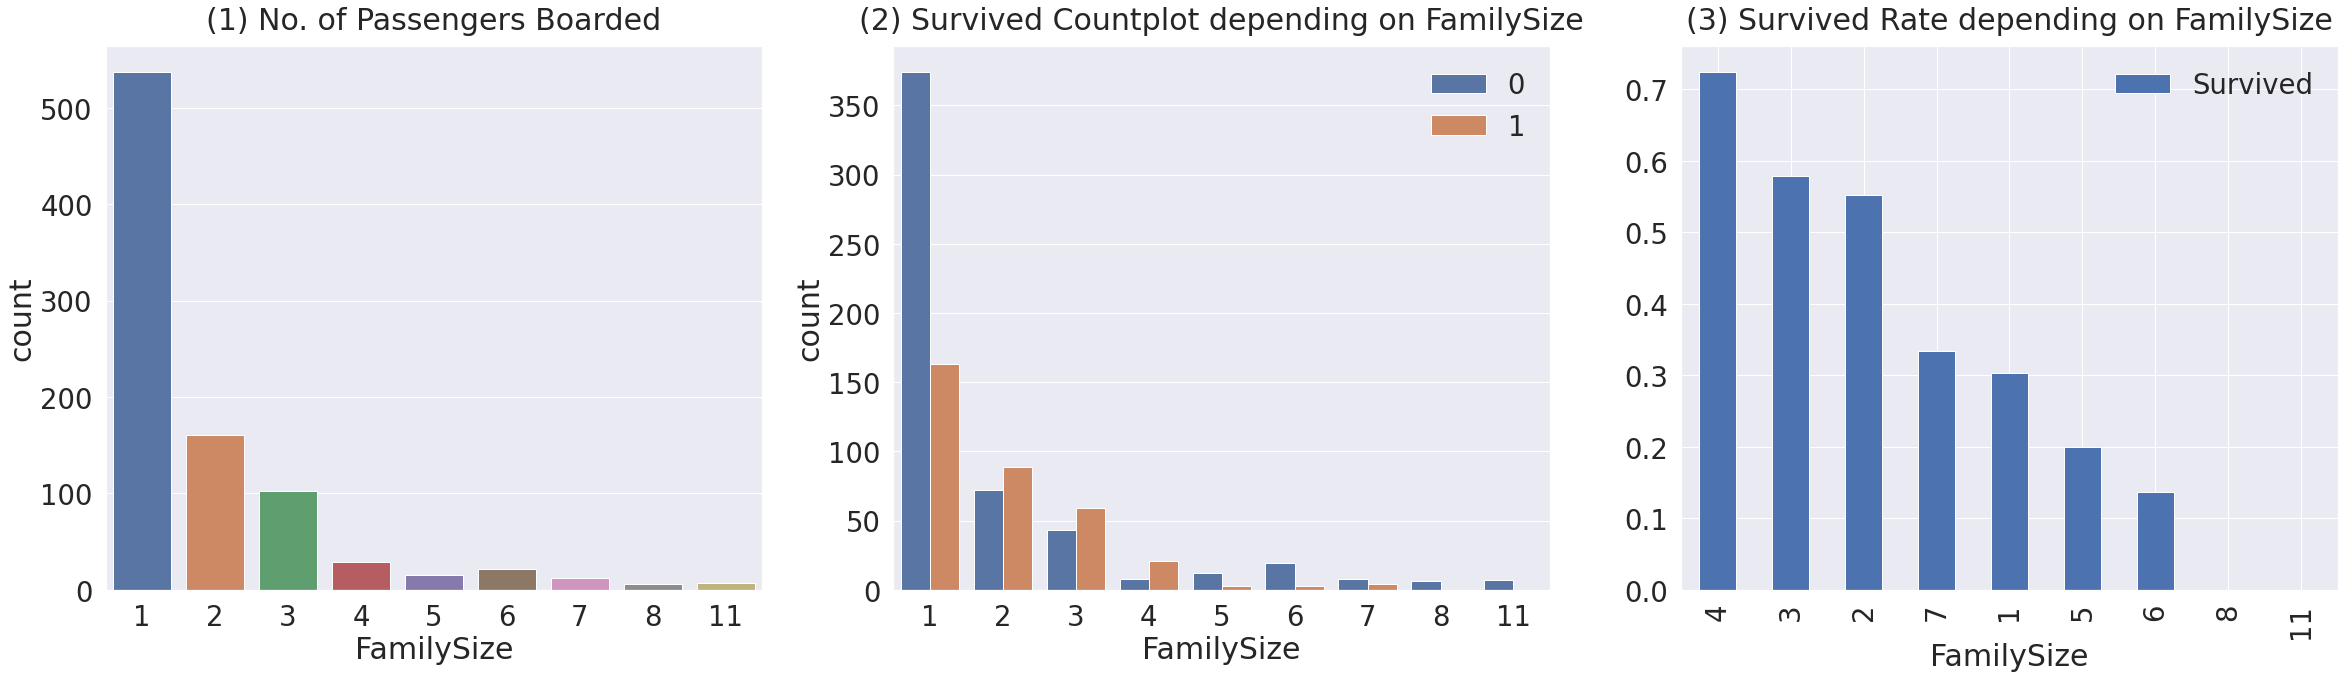

In [92]:
f, ax = plt.subplots(1, 3, figsize=(40, 10))
sns.countplot('FamilySize', data=df_train, ax=ax[0])
ax[0].set_title('(1) No. of Passengers Boarded', y=1.02)

sns.countplot('FamilySize', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Survived Countplot depending on FamilySize', y=1.02)
ax[1].legend(loc='upper right')

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived Rate depending on FamilySize', y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

- Figure(1) -> 가족 크기가 1~11까지 있음을 볼 수 있습니다. 대부분 1명이고 그 다음으로 2,3,4명입니다.
- Figure(2), (3) -> 가족 크기에 따른 생존비교입니다. 가족이 4명인 경우가 가장 생존확률이 높습니다. 가족수가 많아질수록(5,6,7,8,11) 생존확률이 낮아집니다. 가족수가 너무 작아도(1), 너무 커도(5,6,8,11) 생존확률이 낮음을 볼 수 있습니다. 3~4명 선에서 생존확률이 높은 것을 확인할 수 있습니다.

## 2.8 Fare

- Fare는 탑승요금이며, continuous feature입니다. 한번 histogram을 그려보겠습니다.

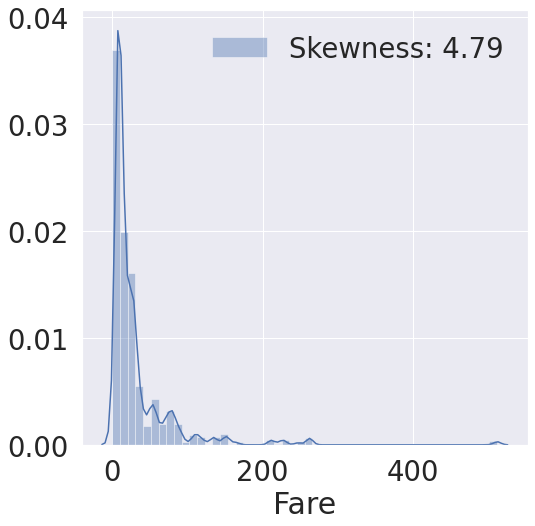

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness: {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

- 보시다시피, distribution이 매우 비대칭인 것을 알 수 있습니다. (high skewness) 만약 이대로 모델에 넣어준다면 자칫 모델이 잘못 학습할 수도 있습니다. 몇개 없는 outlier에 대해서 너무 민감하게 반응한다면, 실제 예측시에 좋지 못한 결과를 부를 수 있습니다.
- outlier의 영향을 줄이기 위해 Fare에 log를 취하겠습니다.
- 여기서 우리는 pandas의 유용한 기능을 사용할 것입니다. dataFrame의 특정 columns에 공통된 작업(함수)를 적용하고 싶으면 아래의 map, 또는 apply를 사용하면 매우 손쉽게 적용할 수 있습니다.
- 우리가 지금 원하는 것은 Fare columns의 데이터 모두에 log값을 취하는 것인데, 파이썬의 간단한 lamda함수를 이용해 간단한 로그를 적용하는 함수를 map에 인수로 넣어주면, Fare columns 데이터에 그대로 적용됩니다. 매우 유용한 기능이니 꼭 숙지하세요!

In [94]:
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean() #testset에 있는 nan vaulue를 평균값으로 치환합니다.

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if  i > 0 else 0)
df_test['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

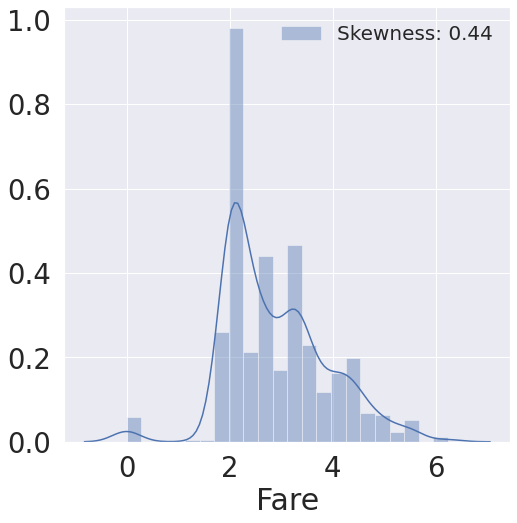

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness: {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best', prop={'size': 20})

- log를 취하니, 이제 비대칭성이 많이 사라진 것을 볼 수 있습니다.
- 우리는 이런 작업을 사용해 모델이 좀 더 좋은 성능을 내도록 할 수 있습니다.
- 사실 방금한 것은 feature engineering에 들어가는 부분인데, 여기서 작업했습니다.
- 모델을 학습시키기 위해, 그리고 그 모델의 성능을 높이기 위해 feature들에 여러 조작을 가하거나, 새로운 feature를 추가하는 것을 feature engineering 이라고 하는데 우리는 이제 그것을 살펴볼 것입니다.

## 2.9 Cabin

- 이 feature는 NaN이 대략 80%이므로 생존에 영향을 미칠 중요한 정보를 얻어내기가 쉽지 않습니다. 
- 그러므로 우리가 세우려는 모델에 포함시키지 않도록 하겠습니다.

In [96]:
df_train.Cabin.isnull().count() / (df_train.Cabin.count() + df_train.Cabin.isnull().count())

0.8136986301369863

## 2.10 Ticket

- 이 feature는 NaN은 없습니다. 일단 string data이므로 우리가 어떤 작업들을 해주어야 실제 모델에 사용할 수 있는데, 이를 위해선 사실 아이디어가 필요합니다.

In [97]:
df_train['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
324669      1
8471        1
29108       1
35851       1
3101276     1
Name: Ticket, Length: 681, dtype: int64

- 보시다시피, ticket number는 매우 다양합니다. 우리는 여기서 어떤 특징을 이끌어내서 생존과 연결시킬 수 있을까요?
- 튜토리얼이니 일단 ticket은 넘기도록 하겠습니다. 튜토리얼을 끝낸 후, 여러분의 모델의 성능을 향상시키기 위해 ticket에서 정보를 이끌어내는 것도 좋겠네요

# 3. Feature Engineering

- 본격적인 feature engineering을 시작해보겠습니다.
- 가장 먼저 dataset에 존재하는 null data를 채우려고 합니다.
- 아무 숫자로 채울 수는 없고, null data를 포함하는 feature의 statistics를 참고하거나, 다른 아이디어를 짜내어 채울 수 있습니다.
- null data를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있기 때문에 신경써야할 부분입니다.
- Feature Engineeing은 실제 모델의 학습에 쓰려고 하는 것이므로, train 뿐만 아니라 test도 똑같이 적용해주어야 합니다.

## 3.1 Fill Nul
### 3.1.1 Fill Null in Age using Title

- Age에는 null data가 177개나 있습니다. 이를 태울 수 잇는 여러 아이디어가 있을 것인데, 여기서 우리는 title + statistics 를 사용해보겠습니다.
- 영어에서 Miss, Mr, Mrs 같은 title이 존재합니다. 각 탑승객의 이름에는 꼭 이런 title이 들어가게 되는데 이를 사용해보겠습니다.
- pandas series에는 data를 string으로 바꿔주는 str method, 거기에 정규표현식을 적용하게 해주는 extract method가 있습니다. 이를 사용하여 title을 쉽게 추출할 수 있습니다. title을 initial columns에 저장하겠습니다.

In [98]:
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')

- pandas의 crosstab을 이용하여 우리가 추출한 Initial과 Sex간의 count를 살펴봅시다.

In [99]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='Set2') #checking the Initial with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


- 위 table을 참고하여 남자, 여자가 쓰는 Initial을 구분해 보겠습니다. replace 메소드를 사용하면 특정 데이터 값을 원하는 값으로 치환해줍니다.

In [100]:
df_train['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don', 'Dona'],
                            ['Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other', 'Other', 'Other', 'Mr', 'Mr', 'Mr', 'Mr'], inplace=True)
df_test['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don', 'Dona'],
                           ['Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other', 'Other', 'Other', 'Mr', 'Mr', 'Mr', 'Mr'], inplace=True)


In [101]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- 여성과 관계있는 Miss, Mrs가 생존률이 높은 것을 볼 수 있습니다. 

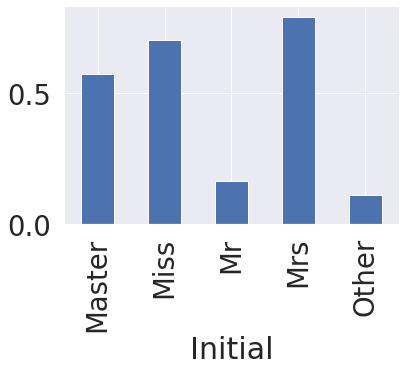

In [102]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

- 이제 본격적으로 Null을 채울 것입니다. null data를 채우는 방법은 정말 많이 존재합니다. statistics를 활용하는 방법도 있고, null data가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있습니다. 여기서는 statistics를 활용하는 방법을 사용할 것입니다.
- 여기서 statistics는 train data의 것을 의미합니다. 우리는 언제나 test를 unseen으로 둔 상태로 놔둬야하며, train에서 얻는 statisics를 기반으로 test의 null data를 채워줘야 합니다.

In [103]:
df_train.groupby('Initial')['Age'].mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

- Age의 평균을 이용해 Null value를 채우도록 하겠습니다.
- pandas dataframe을 다룰 때에는 boolean array를 이용해 indexing하는 방법이 참으로 편리합니다.
- 아래 코드 첫줄을 해석하자면, isnull()이면서 Initial이 Mr인 조건을 만족하는 row(탑승객)의 'Age'의 값을 33으로 치환한다 입니다. 
- loc + boolean + column을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해집시다.

In [104]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial == 'Mr'), 'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial == 'Mrs'), 'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial == 'Master'), 'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial == 'Miss'), 'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial == 'Other'), 'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial == 'Mr'), 'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial == 'Mrs'), 'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial == 'Master'), 'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial == 'Miss'), 'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial == 'Other'), 'Age'] = 46

- 여기선 간단하게 Null을 채웠지만, 좀 더 다양한 방법을 쓴 예시들이 다른 커널에 존재합니다. 
- https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling 보시면서 공부해보세요!

### 3.1.2 Fill Null in Embarked

In [105]:
print('Embarked has', sum(df_train['Embarked'].isnull()), 'Null values')

Embarked has 2 Null values


- Embarked는 Null value가 2개이고, S에서 가장 많은 탑승객이 있었으므로, 간단하게 Null을 S로 채우겠습니다.
- dataframe의 fillna method를 이용하면 쉽게 채울 수 있습니다. 여기서 inplace=True로 하면 df_train에 fillna를 실제로 적용하게 됩니다.

In [106]:
df_train['Embarked'].fillna('S', inplace=True)

## 3.2 Change Age(continuous to categorical)

- Age는 현재 continuous feature입니다. 이대로 써도 모델을 세울 수 있지만, Age를 몇개의 group으로 나누어 category화 시켜줄 수도 있습니다. continuous를 categorical로 바꾸면 자칫 information loss가 생길 수도 있습니다만, 본 튜토리얼에서는 다양한 방법을 소개하는 것이 목적이므로 진행하도록 하겠습니다.

- 방법은 여러가지가 있습니다. dataframe의 indexing방법인 loc를 사용하여 직접해줄 수 있고, 아니면 apply를 사용해 함수를 넣어줄 수 있습니다.
- 첫째로 loc를 사용한 방법입니다. loc는 자주 쓰게 되므로 그 사용법을 숙지하시면 좋습니다.
- 나이는 10살 간격으로 나누겠습니다.

In [107]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

- 두번째로 간단한 함수를 만들어 apply 메소드를 넣어주는 방법입니다. 훨씬 수월합니다.

In [108]:
def category_age(x):
    if x <10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7

df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

- 두 가지 방법이 잘 적용되었다면, 둘 다 같은 결과를 내야합니다.
- 이를 확인하기 위해 Series 간 boolean 비교 후 all() 메소드를 사용합시다. all() 메소드는 모든 값이 True이면 True, 하나라도 False가 있으면 False를 반환합니다. 

In [109]:
print('1번 방법, 2번 방법 둘 다 같은 결과가 나오면 True ->', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘 다 같은 결과가 나오면 True -> True


- 보시다시피 True입니다. 둘 중 편한 걸 선택하시면 됩니다.
- 이제 중복되는 Age_cat_2 컬럼과 원래 컬럼 Age를 제거하겠습니다.

In [110]:
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

## 3.3 Change Initial, Embarked and Sex(string to numerical)

- 현재 Initial은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있습니다. 이런 카테고리로 표현되어져 있는 데이터를 모델에 인풋으로 넣어줄 때 우리가 해야할 것은 먼저 컴퓨터가 인식할 수 있도록 수치회시켜야 합니다.
- map method를 가지고 간단히 할 수 있습니다.
- 사전 순서대로 정리하여 mapping하겠습니다.

In [111]:
df_train['Initial'] = df_train['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})
df_test['Initial'] = df_test['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})

- Embarked도 C, Q, S로 이루어져있습니다. map을 이용해 바꿔봅시다. 
- 그러기 앞서, 특정 column에 어떤 값들이 있는지 확인해보는 방법을 잠깐 살펴보겠습니다. 간단히 unique() 메소드를 쓰거나, value_counts()를 써서 count 까지 보는 방법이 있습니다.

In [112]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [113]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

- 위 두 방법을 사용해 Embarked가 S, C, Q 세가지로 이루어진 것을 볼 수 있습니다. 이제 map을 사용해봅시다.

In [114]:
df_train['Embarked'] = df_train['Embarked'].map({'C':0, 'Q':1, 'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0, 'Q':1, 'S':2})

- 한번 Null이 사라졌는지 확인해봅시다. Embarked column만 가져온 것은 하나의 pandas의 Series 객체이므로, isnull() 메소드를 사용해 Series의 값들이 null인지 아닌지에 대한 boolean값을 얻을 수 있습니다. 그리고 이것에 any()를 사용하여, True가 단 하나라도 있을 시(Null이 한개라도 있을 시) True를 반환해주게 됩니다. 우리는 Null을 S로 다 바꿔주었으므로 False를 얻게 됩니다.

In [115]:
df_train['Embarked'].isnull().any()

False

- Sex도 female, male로 이루어져 있습니다. map을 이용하여 바꿔봅시다.

In [116]:
df_train['Sex'] = df_train['Sex'].map({'female':0, 'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0, 'male':1})

- 이제 각 feature간의 상관관계를 한번 보려고 합니다. 두 변수 간의 Pearson correlation을 구하면 (-1, 1) 사이의 값을 얻을 수 있습니다. -1로 갈수록 음의 상관관계, 1로 갈수록 양의 상관관계를 의미하며, 0은 상관관계가 없다는 것을 의미합니다. 구하는 수식은 다음과 같습니다.

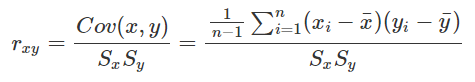

- 우리는 여러 feature를 가지고 있으니 이를 하나의 matrix형태로 보면 편할텐데, 이를 heatmap plot이라고 하며, dataframe의 corr() 메소드와 seaborn을 가지고 편하게 그릴 수 있습니다. 

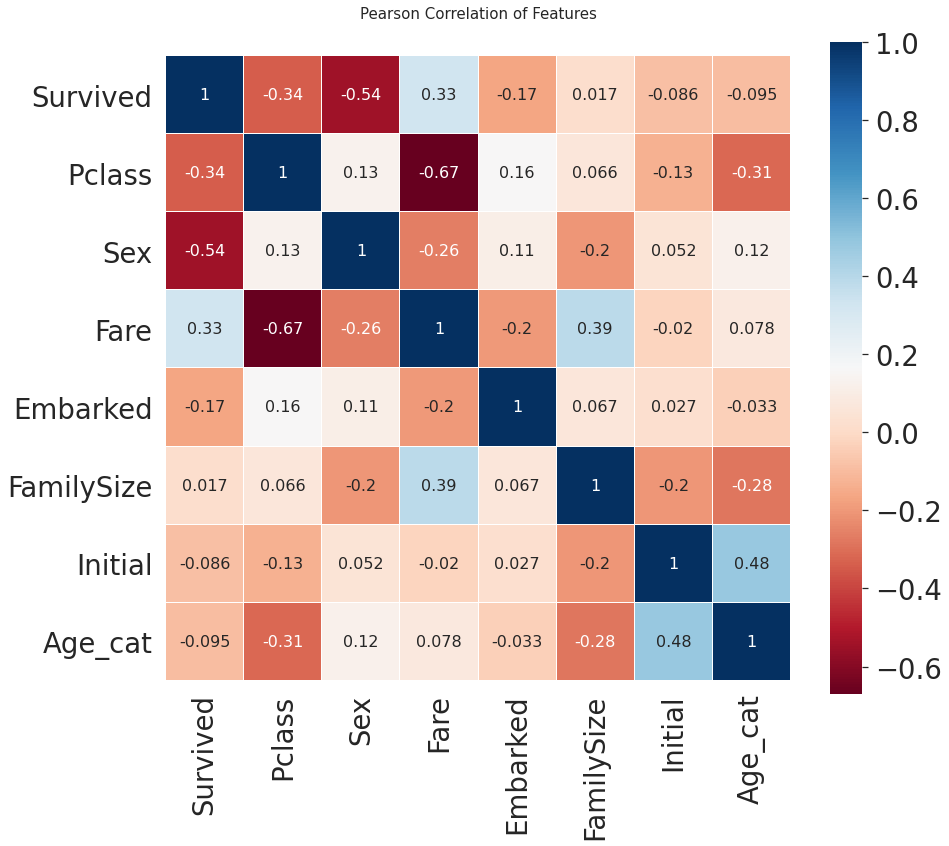

In [117]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={'size':16})

del heatmap_data

- 우리가 EDA에서 살펴봤듯이, Sex와 Pclass가 Survived에 상관관계가 어느정도 있음을 볼 수 있습니다.
- 생각보다 fare와 Embarked도 상관관계가 있음을 볼 수 있습니다. 
- 또한 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 가지는 feature들이 없다는 것입니다.
- 이것은 우리가 모델을 학습시킬 때, 불필요한(redundant, superfluous) feature가 없다는 것을 의미합니다. 1 또는 -1의 상관관계를 가진 feature A, B가 있다면, 우리가 얻을 수 있는 정보는 사실 하나일 거니까요.
- 이제 실제로 모델을 학습시키기 앞서 data preprocessing(전처리)를 진행해보겠습니다. 

## 3.4 One-hot encoding on Initial and Embarked

- 수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해줄 수 있습니다.
- 수치화는 간단히 Master = 0, Miss = 1, Mr = 2, Mrs = 3, Other = 4로 매핑해주는 것을 말합니다.
- One-hot encoding은 위 카테고리를 아래와 같이 (0,1)로 이루어진 5차원 벡터로 나타내는 것을 말합니다.

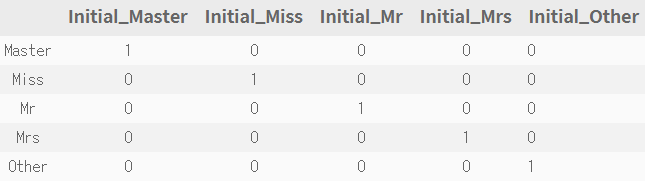

- 위와 같은 작업을 직접 코딩할 수도 있지만, pandas의 get_dummies를 사용하여 쉽게 해결할 수 있습니다.
- 총 5개의 카테고리이니, one-hot encoding을 하고 나면 새로운 5개의 column이 생겨납니다.
- Initial을 prefix로 두어서 구분이 쉽게 만들어 줍니다.

In [119]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [121]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


- 보시다시피 오른쪽에 우리가 만들려고 했던 one-hot encoded columns가 생성된 것이 보입니다. 

- Embarked에도 적용하겠습니다. Initial 때와 마찬가지로 one-hot encoding을 사용해 표현하겠습니다. 

In [122]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

- 아주 쉽게 one-hot encoding을 적용했습니다.
- sklearn으로 Labelencoder + OneHotencoder을 이용해도 one-hot encoding이 가능합니다. 
- 여기서는 get_dummies만으로 충분히 가능하기에 이걸로만 수행했습니다.
- 가끔 category가 100개가 넘어가는 경우가 있습니다. 이때 one-hot encoding을 사용하면 column이 100개 이상 생겨, 학습시 매우 버거울 경우가 있습니다. 이런 경우는 다른 방법을 사용하기도 하는데, 이는 다음에 다뤄봅시다.

## 3.5 Drop columns

- 필요한 columns만 남기고 다 지웁시다. 

In [123]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [124]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [125]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,0.683603,1,3,0,0,1,0,0,0,1,0
1,3,0,1.450832,2,4,0,0,0,1,0,0,0,1
2,2,1,0.727559,1,6,0,0,1,0,0,0,1,0
3,3,1,1.379314,1,2,0,0,1,0,0,0,0,1
4,3,0,0.735091,3,2,0,0,0,1,0,0,0,1


- 보시다시피 train의 Survived feature(target class)를 빼면 train, test 둘 다 같은 columns를 가진 걸 확인할 수 있습니다. 

# 4. Building Machine Learning Model and Prediction using the Trained Model

- 이제 준비가 다 되었으니 sklearn을 사용해 본격적으로 머신러닝 모델을 만들어 봅시다.

In [126]:
#importinf all the required ML packages
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics #모델 평가 위함
from sklearn.model_selection import train_test_split #training set을 쉽게 나눠주는 함수

- Sklearn은 머신러닝의 처음부터 끝까지가 다 있습니다. feature engineering, preprocessing, 지도 학습 알고리즘, 비지도 학습 알고리즘, 모델 평가, 파이프라인 등 머신러닝에 관련괸 모든 작업들이 손쉬운 인터페이스로 구현되어 있습니다. 데이터 분석 + 머신러닝을 하고 싶다면, 이 라이브러리는 반드시 숙지해야 합니다.

- 지금 타이타닉 문제는 target class(Survived)가 있으며, target class는 0, 1로 이루어져 있으므로(binary) binary classification 문제입니다.
- 우리가 지금 가지고 있는 train set의 Survived를 제외한 input을 가지고 모델을 최적화시켜서 각 샘플(탑승객)의 생존 유무를 판단하는 모델을 만들어냅니다.
- 그 후 모델이 학습하지 않았던 test set을 input으로 주어서 test set의 각 샘플(탑승객)의 생존 유무를 예측해봅니다.

## 4.1 Preparation - Split dataset into train, valid, test set

- 가장 먼저, 학습에 쓰일 데이터와, target label(Survived)를 분리합니다. drop을 사용해 간단히 할 수 있습니다.

In [127]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

- 보통 train, test만 언급되지만, 실제 좋은 모델을 만들기 뤼해서 우리는 valid set을 따로 만들어 모델 평가를 해봅니다.
- 마치 축구대표팀이 팀 훈련(train)을 하고 바로 월드컵(test)으로 나가는것이 아니라, 팀 훈련(train)을 한 다음 평가전(valid)을 거쳐 팀의 훈련정도(학습정도)를 확인하고 월드컵(test)에 나가는 것과 비슷합니다.
- train_test_split을 사용하여 쉽게 train set을 분리할 수 있습니다.

In [129]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2020)

- sklearn에서는 여러 머신러닝 알고리즘을 지원해줍니다. 열거하기엔 너무 많으므로, 직접 documentation에 들어가 보길 추천합니다. http://scikit-learn.org/stable/supervised_learning.html#supervised-learning
- 본 튜토리얼에서는 랜덤포레스트 모델을 사용하도록 하겠습니다.
- 랜덤포레스트는 결정트리기반 모델이며, 여러 결정트리들을 앙상블한 모델입니다. 더 구체적인 모델 설명은 여러 블로그들을 참고하면 됩니다.
- 각 머신러닝 알고리즘에는 여러 파라미터들이 있습니다. 랜덤포레스트 분류기도 n_estimators, max_fetures, max_depth, min_samples_split, min_samples_leaf 등 여러 파라미터들이 존재합니다. 이걸들이 어떻게 세팅되냐에 따라 같은 데이터셋이라 하더라도 모델의 성능이 달라집니다.
- 파라미터 튜닝은 시간, 경험, 알고리즘에 대한 이해 등이 필요합니다. 결국 많이 써봐야 모델도 잘 세울 수 있는 것이죠. 여러 데이터셋을 가지고 모델을 이리저리 써봐야 튜닝하는 감이 생길테니까요!
- 일단 지금은 튜토리얼이니 파라미터 튜닝은 잠시 제쳐두기로 하고, 기본 default 세팅으로 진행하겠습니다.
- 모델 객체를 만들고, fit 메소드로 학습시킵니다.
- 그런 후 valid set input을 넣어주어 예측값(X_vld sample(탑승객)의 생존 여)를 얻습니다. 

## 4.2 Model Generation and Prediction

In [138]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

- 단 세 줄만으로 모델을 세우고, 예측까지 했습니다.
- 모델의 성능을 한번 살펴보겠습니다.

In [139]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 82.46% 정확도로 생존을 맞춤


- 아무런 파라미터 튜닝을 하지 않았는데도 82%의 정확도가 나왔습니다.

## 4.3 Feature Importance

- 학습된 모델은 feature importance를 가지게 되는데, 우리는 이것을 확인하여 지금 만들 모델이 어떤 feature에 영향을 많이 받았는지 확인할 수 있습니다.
- 쉽게 말해, 10 = (4 * x1) + (2 * x2) + (1 * x3)을 생각하면, 우리는 x1이 결과값(10)에 큰 영향을 준다고 생각할 수 있습니다. feature importance는 4, 2, 1을 이야기하며, x1이 가장 큰 값(4)를 가지므로, 이 모델에 가장 큰 영향을 미친다고 말할 수 있습니다. 

- 학습된 모델은 기본적으로 feature importances를 가지고 있어서 쉽게 그 수치를 얻을 수 있습니다.
- pandas series를 이용하면 쉽게 sorting하여 그래프를 그릴 수 있습니다.

In [140]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

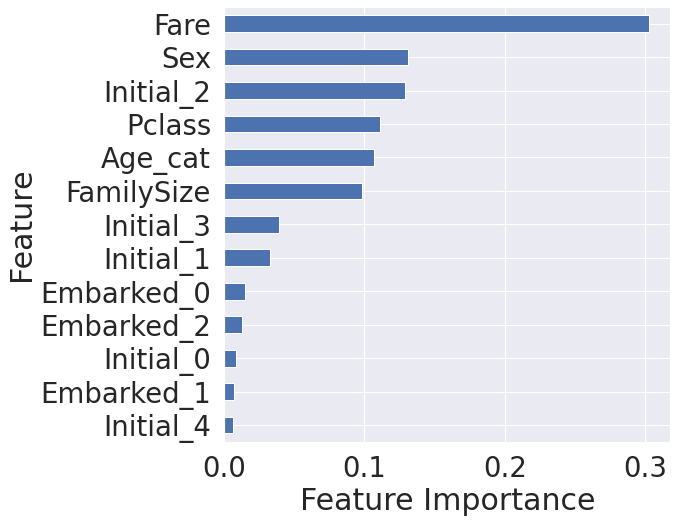

In [141]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

- 우리가 얻은 모델에서는 Fare가 가장 큰 영향력을 가지며, 그 뒤로 Sex, Initial_2, Pclass, Age_cat이 차례로 중요도를 가집니다. 
- 사실 feature importance는 지금 모델에서의 importance를 나타냅니다. 만약 다른 모델을 사용하게 된다면 feature importance가 다르게 나올 수 있습니다.
- 이 feature importance를 보고 실제로 Fare가 중요한 feature일 수 있다고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 좀 더 살펴보긴 해야합니다.
- feature importance를 가지고 좀 더 정확도가 높은 모델을 얻기 위해 feature selection을 할 수도 있고, 좀 더 빠른 모델을 위해 feature를 제거할 수도 있습니다. 

## 4.4 Prediction on Test Set

- 이제 모델이 학습하지 않았던 테스트셋을 모델에 주어서 생존여부를 예측해보겠습니다.
- 이 결과는 실제로 submission(제출용)이므로 결과는 leaderboard에서 확인할 수 있습니다.
- 캐글에서 준 파일, gender_submission.csv파일을 읽어서 제출 준비를 하겠습니다. 

In [142]:
submission = pd.read_csv('../input/titanic/gender_submission.csv')

In [143]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


- 이제 testset에 대하여 예측을 하고, 결과를 csv 파일로 저장해보겠습니다.

In [144]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [145]:
submission.to_csv('./my_first_submission.csv', index=False)

- 이제 캐글에 제출해보도록 합시다.

# 5. Conclusion

- titanic dataset을 가지고 data science를 경험해보셨습니다. 
- 이걸로 끝이 아닙니다. 앞으로 배울 것이 무궁무진합니다.
- 좀 더 참신한 feature engineering, 머신러닝 모델, hyperparameter tunning, ensembling 등 무궁무진 합니다.